# My Steam Library Analysis

In this project I tried to analyse my preferences on video games, and tried to develop a model to predict if a game is fitting to my preferences. My main hypothesis is that more I play a game relative to its intended playtime, higher my score for the game is.

Now, we import the necessary libraries.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import string
import time
import ast
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from selenium.webdriver import Firefox
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from bs4 import BeautifulSoup
from collections import Counter

We go to the steam page of my library. Steam asks to sign in to an account (not mine particularly, just any account), so if you don't have an account you can use the SteamLib.html by entering file directory.

In [4]:
driver = Firefox()
driver.get("https://steamcommunity.com/profiles/76561198141206466/games/?tab=all")
#driver.get("file:///C:/Users/Berke%20Tatar/Downloads/SteamLib.html")

We get the html and find the table.

In [5]:
html_content = driver.page_source
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('div', class_='gameslistitems_List_3tY9v Panel Focusable')

Now we go to the individual store pages of the games and get the review amount, positive review percentage and the list of games tags. In certain games Steam asks for age verification, which we will answer saying we were born in January 1, 1901. :D

In [6]:
# Initialize an empty list to store the table data
table_data = []

# Find all rows in the table
for row in table.find_all('div', class_='gameslistitems_GamesListItemContainer_29H3o'):
    # Initialize a list for each row
    row_data = []

    # Find the game name and append to row_data
    game_name = row.find('a', class_='gameslistitems_GameName_22awl')
    row_data.append(game_name.text if game_name else 'N/A')

    # Find the playtime and append to row_data
    fact_label = row.find('span', class_='gameslistitems_Hours_26nl3')
    row_data.append(fact_label.text[12:] if fact_label else 'N/A')

    # Find the store link
    href_label = row.find('a', class_='gameslistitems_GameName_22awl')
    href_value = href_label.get('href')
    driver.get(href_value)
    #time.sleep(2)
    try:
        review_element = driver.find_element(By.ID, 'userReviews')
    
    #If it can't find the element it means it got stuck in the age verification.
    except NoSuchElementException:             
        try:
            #Select Year Box
            dropdown_element = driver.find_element(By.ID, 'ageYear')
            dropdown = Select(dropdown_element)

            # Select 1901
            dropdown.select_by_index(1)
            driver.find_element(By.ID, "view_product_page_btn").send_keys(Keys.RETURN)
            time.sleep(3)
            
            #Check again
            review_element = driver.find_element(By.ID, 'userReviews')
        except NoSuchElementException:
            review_element = None
                
    if review_element:
        #Get reviews
        review_html = review_element.get_attribute('outerHTML')
        soup2 = BeautifulSoup(review_html, 'html.parser')
        reviews = soup2.find_all('span', class_="nonresponsive_hidden responsive_reviewdesc")
        
        #Get tags
        tag_element = driver.find_element(By.ID, 'glanceCtnResponsiveRight')
        tag_html = tag_element.get_attribute('outerHTML')
        soup2 = BeautifulSoup(tag_html, 'html.parser')
        tags = soup2.find_all('a', class_="app_tag")
        tags = [tag.text.strip() for tag in tags]
    else:
        reviews = None
        
    if reviews:
        #If there are recent reviews the reviews are split as recent and total, in that case get the total reviews.
        if len(reviews) == 1:
            row_data.append(reviews[0].text.split(" ")[1])
            row_data.append(reviews[0].text.split(" ")[4])
        else:
            row_data.append(reviews[1].text.split(" ")[1])
            row_data.append(reviews[1].text.split(" ")[4])
    else:
        row_data.append(pd.NA)
        row_data.append(pd.NA)
    row_data.append(tags)
    
    # Append the row_data to table_data
    table_data.append(row_data)  

We will add the values to the dataframe after processing them.

In [10]:
# Get table rows and extract row data
columns = ['Game', 'Playtime', 'Review_Percent', 'Review_Amount', 'Tags']
df = pd.DataFrame(table_data, columns=columns)
# Assuming df is your DataFrame and 'Duration' is the column you want to convert
df['Numeric_Playtime'] = df['Playtime'].str.extract('(\d+\.\d+|\d+)').astype(float)

# Create a new column 'Unit' to identify whether the duration is in hours or minutes
df['Unit'] = df['Playtime'].str.extract('(hours|minutes)')

# Convert the 'Numeric_Duration' to hours for rows where the unit is 'minutes'
df.loc[df['Unit'].str.lower() == 'minutes', 'Numeric_Playtime'] /= 60

# Drop the 'Unit' column if it's no longer needed
df.drop(columns=['Unit'], inplace=True)
df['Playtime'] = round(df['Numeric_Playtime'], 1)
df.drop(columns=['Numeric_Playtime'], inplace=True)

# Assuming df is your DataFrame and 'Review_Percent' is the column you want to convert
df['Review_Percent'] = df['Review_Percent'].str.rstrip('%')
# Replace missing values with 0 or any other suitable value
df['Review_Percent'].fillna(0, inplace=True)
# Convert the 'Review_Percent' to integers
df['Review_Percent'] = df['Review_Percent'].astype(int)

df['Review_Amount'] = df['Review_Amount'].str.replace(',', '')
df['Review_Amount'].fillna(0, inplace=True)
df['Review_Amount'] = df['Review_Amount'].astype(int)

print(df)

                                  Game  Playtime  Review_Percent  \
0                 Kerbal Space Program     303.5              95   
1                  Oxygen Not Included     298.7              96   
2                     Counter-Strike 2     250.0              87   
3                             Terraria     211.4              97   
4                    Enter the Gungeon     154.9              95   
..                                 ...       ...             ...   
118  The Stanley Parable: Ultra Deluxe       NaN              94   
119                           Tokyo 42       NaN              71   
120                         Transistor       NaN              93   
121                      Void Bastards       NaN              87   
122                    Warface: Clutch       NaN              66   

     Review_Amount                                               Tags  
0            96570  [Space, Simulation, Sandbox, Physics, Science,...  
1           103743  [Colony Sim, Base B

Until this point if there were a problem you can run the line below to use the prepared csv file.

In [11]:
df = pd.read_csv("SteamLib.csv")

We can check some general info about the dataset.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Game            123 non-null    object 
 1   Playtime        97 non-null     float64
 2   Review_Percent  123 non-null    int64  
 3   Review_Amount   123 non-null    int64  
 4   Tags            123 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ KB


We can check the tags and their occurences. Here, you can see that I mostly perefer Indie games and tags that will be related to Indie games usually -such as Singleplayer and 2D- are predictably common.

In [13]:
# Assuming df['Tags'] contains a string representation of a list
df['Tags'] = df['Tags'].apply(ast.literal_eval)

# Flatten the list of lists into a single list
all_tags = [tag.strip() for tag_list in df['Tags'] for tag in tag_list]

# Count the occurrences of each tag
tag_counts = Counter(all_tags)

# Convert the Counter to a DataFrame for easier analysis
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['Tag', 'Count'])

tag_counts_df = tag_counts_df.sort_values(by='Count', ascending=False)

# Display the sorted DataFrame
print(tag_counts_df.head(20))

unique_tags_count = tag_counts_df['Tag'].nunique()

print(f"Number of unique tags: {unique_tags_count}")

                  Tag  Count
8               Indie     98
11       Singleplayer     97
30             Action     77
25                 2D     76
16          Adventure     70
74   Great Soundtrack     59
44     Pixel Graphics     54
18           Strategy     50
48        Atmospheric     50
13              Funny     44
26        Multiplayer     44
15          Difficult     44
46                RPG     39
88         Story Rich     39
37              Co-op     35
1          Simulation     35
10         Open World     32
51          Roguelike     29
120            Puzzle     29
2             Sandbox     28
Number of unique tags: 273


We can look at the games I played the most. (I suggest playing Kerbal Space Program to everyone who are interested in space travel.)

In [14]:
print(df.sort_values(by="Playtime", ascending=False).head(20))

                             Game  Playtime  Review_Percent  Review_Amount  \
0            Kerbal Space Program     303.5              95          96570   
1             Oxygen Not Included     298.7              96         103743   
2                Counter-Strike 2     250.0              87        7841821   
3                        Terraria     211.4              97         989722   
4               Enter the Gungeon     154.9              95          68478   
5                Darkest Dungeon®     107.5              91         113719   
6                Prison Architect      82.6              90          54722   
7          FTL: Faster Than Light      70.0              95          55289   
8           Don't Starve Together      66.2              95         298196   
9          Mount & Blade: Warband      60.7              97         122591   
10                Space Engineers      58.0              89          90680   
11                   Don't Starve      57.9              96     

We can look at the games with highest review amounts. Initially, I considered scraping the games' player amounts from a SteamAPI site, but then figured the review amounts are a rather good indicator of a games popularity. So these games can be considered the most popular. (I do not suggest playing Counter-Strike.)

In [15]:
print(df.sort_values(by="Review_Amount", ascending=False).head(20))

                                     Game  Playtime  Review_Percent  \
2                        Counter-Strike 2     250.0              87   
3                                Terraria     211.4              97   
27                         Stardew Valley      24.2              98   
20                               Unturned      34.9              91   
93                               PAYDAY 2       0.8              89   
64                                   DayZ       5.9              75   
8                   Don't Starve Together      66.2              95   
116         The Binding of Isaac: Rebirth       NaN              97   
15            Sid Meier's Civilization VI      48.7              86   
89                        Project Zomboid       1.0              94   
13                              Undertale      55.5              96   
85                          Borderlands 2       1.3              95   
95                                   Muck       0.0              94   
65    

We can look at the positive review percentages. An interesting trend I noticed is that the niche games have tendecies to have higher percentages, while increase in popularity usually decrease the positive review percentage. Stardew Valley is the most popular game among the 98% range and Terraria is the most popular among the 97% range.

In [16]:
print(df.sort_values(by="Review_Percent", ascending=False).head(20))

                                     Game  Playtime  Review_Percent  \
46        Don't Escape: 4 Days to Survive       9.4              98   
27                         Stardew Valley      24.2              98   
111                   Power of Ten - Demo       NaN              98   
75                            Baba Is You       2.6              98   
9                  Mount & Blade: Warband      60.7              97   
73                               Gunpoint       2.7              97   
28                         Slay the Spire      21.7              97   
14                               Broforce      55.2              97   
40                                Celeste      13.2              97   
32                          Hotline Miami      18.2              97   
26   Plants vs. Zombies: Game of the Year      24.2              97   
47                               Fran Bow       9.2              97   
108                                 OMORI       NaN              97   
110   

Now we will get the average time it took players to finish a game from HowLongToBeat.

In [22]:
driver.get("https://howlongtobeat.com/steam?userName=76561198141206466")
time.sleep(5)

# Find the table element using Selenium
table = driver.find_element(By.CLASS_NAME, 'steam_steam_table__Ko02C')

# Get the HTML content of the table
table_html = table.get_attribute('outerHTML')

# Use BeautifulSoup to parse the HTML
soup = BeautifulSoup(table_html, 'html.parser')

# Find all rows in the table
rows = soup.find_all('tr')

# Extract column headers
headers = [th.text.strip() for th in rows[0].find_all('td')]

# Extract data from the remaining rows
data = []
for row in rows[1:]:
    row_data = [td.text.strip() for td in row.find_all('td')]
    data.append(row_data)

# Create a Pandas DataFrame
dfHLTB = pd.DataFrame(data, columns=headers)

# Print or do further processing with the DataFrame
print(dfHLTB)

                                         Name HLTB Time Playtime Import  Link
0                                     8BitMMO    25h 3m   1h 10m  Login      
1                               Ace of Spades   14h 35m  36h 48m  Login      
2               Age of Empires II: HD Edition   67h 51m   3h 20m  Login      
3                                   Air Marty    2h 14m    2h 4m  Login      
4                                       Akane    7h 42m       --  Login      
..                                        ...       ...      ...    ...   ...
115                                   Warface   36h 33m       --  Login      
116                  WorldBox - God Simulator    21h 2m   2h 46m  Login      
117                                 Wreckfest   22h 24m   9h 10m  Login      
118  Wreckfest Throw-A-Santa + Sneak Peek 2.0        --   2h 24m  Login      
119               We Matched 119 of 119 Games      None     None   None  None

[120 rows x 5 columns]


If there was a problem with webscraping, you can use the line below to get the prepared csv.

In [17]:
dfHLTB = pd.read_csv("HLTBLib.csv")

Now, I add my gradings of the games on a scale of 1-4 where 0 is the games I haven't played or played enough to get a idea. Also, I fix the names of 2 games that caused problems in the next cell.

In [18]:
dfSS = pd.read_csv("Self_Score.csv")
df["Self_Score"] = dfSS["Self_Score"]
df.loc[df['Game'] == 'Darkest Dungeon®', 'Game'] = 'Darkest Dungeon'
df.loc[df['Game'] == "The Last Door - Collector's Edition", 'Game'] = 'The Last Door'
print(df.sort_values(by="Self_Score", ascending=False).head(20))

                                  Game  Playtime  Review_Percent  \
0                 Kerbal Space Program     303.5              95   
12                  Kingdom Two Crowns      56.6              91   
50  Getting Over It with Bennett Foddy       8.4              82   
23                                LISA      30.6              95   
1                  Oxygen Not Included     298.7              96   
32                       Hotline Miami      18.2              97   
33                         Inscryption      16.5              96   
19       Hotline Miami 2: Wrong Number      35.8              93   
35                         Titan Souls      16.0              83   
16                  Kingdom: New Lands      45.1              87   
15         Sid Meier's Civilization VI      48.7              86   
13                           Undertale      55.5              96   
4                    Enter the Gungeon     154.9              95   
3                             Terraria     211.4

We will process the HLTB values and add them to the main dataframe. We can see that the games I played a lot also have high HLTB times.

In [19]:
def convert_to_float(time_str):
    try:
        # Split the time string into hours and minutes
        parts = time_str.replace('h', '').replace('m', '').split()
        
        # If there are both hours and minutes
        if len(parts) == 2:
            hours, minutes = map(int, parts)
            total_minutes = hours * 60 + minutes
            return total_minutes / 60.0
        # If there is only one part (either hours or minutes)
        elif len(parts) == 1:
            return float(parts[0])
        else:
            return None  # Handle cases where the format is unexpected
    except:
        return None  # Handle cases where the conversion fails

# Apply the function to the 'HLTB Time' column
dfHLTB["HLTB Time"] = dfHLTB["HLTB Time"].apply(convert_to_float)
dfHLTB['HLTB Time'].fillna(0, inplace=True)
dfHLTB["HLTB Time"] = round(dfHLTB["HLTB Time"], 1)

# Extract the part before " (" in the 'Game' column,
# to avoid certain disparities with games having their release years in their titles in HLTB site
df['Game'] = df['Game'].str.split(r'\(', n=1).str[0].str.strip()
dfHLTB['Name'] = dfHLTB['Name'].str.split(r'\(', n=1).str[0].str.strip()

# Convert 'Game' and 'Name' columns to lowercase
df['Game_lower'] = df['Game'].str.lower()
dfHLTB['Name_lower'] = dfHLTB['Name'].str.lower()

for index, row in df.iterrows():
    game_name_lower = row['Game_lower']

    # Check if the game_name is present in dfHLTB (case-insensitive)
    if game_name_lower in dfHLTB['Name_lower'].values:
        # Assign the corresponding HLTB Time value to the 'HLTB' column in df
        df.at[index, 'HLTB'] = dfHLTB.loc[dfHLTB['Name_lower'] == game_name_lower, 'HLTB Time'].values[0]

# Drop the unnecessary columns
df = df.drop(['Game_lower'], axis=1)
dfHLTB = dfHLTB.drop(['Name_lower'], axis=1)

print(df.sort_values(by="HLTB", ascending=False).head(20))

                              Game  Playtime  Review_Percent  Review_Amount  \
2                 Counter-Strike 2     250.0              87        7841821   
0             Kerbal Space Program     303.5              95          96570   
1              Oxygen Not Included     298.7              96         103743   
93                        PAYDAY 2       0.8              89         423783   
9           Mount & Blade: Warband      60.7              97         122591   
10                 Space Engineers      58.0              89          90680   
116  The Binding of Isaac: Rebirth       NaN              97         246014   
60                 ShellShock Live       6.6              93          27723   
3                         Terraria     211.4              97         989722   
27                  Stardew Valley      24.2              98         544047   
89                 Project Zomboid       1.0              94         204835   
96                       Robocraft       0.0        

Games can have highly varying playtimes, like a sandbox game with content of potentially hundreds of hours versus a 2 hour story based game with low replayability. In this case the higher playtime does not necessarily mean as much, so I will be taking the ratio of my playtime to the HLTB time of the game. You can see that the Playtime_Coefficient for Broforce is 6.2 and for Undertale it is 5.5. Both of these games are linear and have an ending, as the values imply I finished both of them several times. (I suggest them as well.)

In [20]:
df = df.fillna(0)
# Check if 'HLTB' is present in the DataFrame
if 'HLTB' in df.columns:
    # Calculate Playtime_Coefficient based on the ratio of Playtime to HLTB
    df['Playtime_Coefficient'] = np.where(df['HLTB'] != 0, df['Playtime'] / df['HLTB'], 0)
    
    # Replace 0 values with the average of non-zero values
    non_zero_average = df.loc[df['Playtime_Coefficient'] != 0, 'Playtime_Coefficient'].mean()
    df['Playtime_Coefficient'] = np.where(df['Playtime_Coefficient'] == 0, non_zero_average, df['Playtime_Coefficient'])
else:
    # If 'HLTB' is not present, set Playtime_Coefficient to 0
    df['Playtime_Coefficient'] = 0

# Print the DataFrame
print(df.sort_values(by='Playtime_Coefficient', ascending=False).head(20))

                             Game  Playtime  Review_Percent  Review_Amount  \
14                       Broforce      55.2              97          45067   
13                      Undertale      55.5              96         192249   
35                    Titan Souls      16.0              83           6768   
34         TASTEE: Lethal Tactics      16.1              77            147   
21                        Besiege      32.8              95          41813   
19  Hotline Miami 2: Wrong Number      35.8              93          47145   
6                Prison Architect      82.6              90          54722   
7          FTL: Faster Than Light      70.0              95          55289   
29                       DEADBOLT      19.9              96           4254   
32                  Hotline Miami      18.2              97          77097   
18                  Ace of Spades      36.8              65          18464   
4               Enter the Gungeon     154.9              95     

Now we will make the tags that occur more than 20 times into binary variables of whether a game has it or not. 20 might seem like a small number and I preferred it considering my sample size is already small.

In [21]:
# Filter tags that appear more than 20 times
tag_counts = df['Tags'].explode().value_counts()
popular_tags = tag_counts[tag_counts > 20].index

# Create binary columns for each popular tag
tags_df = pd.get_dummies(df['Tags'].explode()).groupby(level=0).sum()
tags_df = tags_df[popular_tags]
df = pd.concat([df, tags_df], axis=1)

We can look at the correlations of different variables, I also excluded the games I haven't played yet.

    Certain general interesting relations are:

-Games with more HLTB time have more reviews(are more popular).

-Action games are more likely to be platformer games and are less likely to be strategy games.

-Sandbox games are more likely to be open world, multiplayer, simulation and building related and less likely to have a great soundtrack.

-Retro games are more likely to have pixel graphics.

-Multiplayer games are more likely to have co-op and be sandbox, but are less likely to be story rich.

-Horror games are more likely to have gore.

    Relations related with my data are:

-Games with higher Playtime_Coefficient(the ones I played more relative to others) received higher scores from me.

-Strongest relation is that I have more playtime in games with higher HLTB time.

-I am more likely to play popular games more.(Likely due to their high HLTB time)

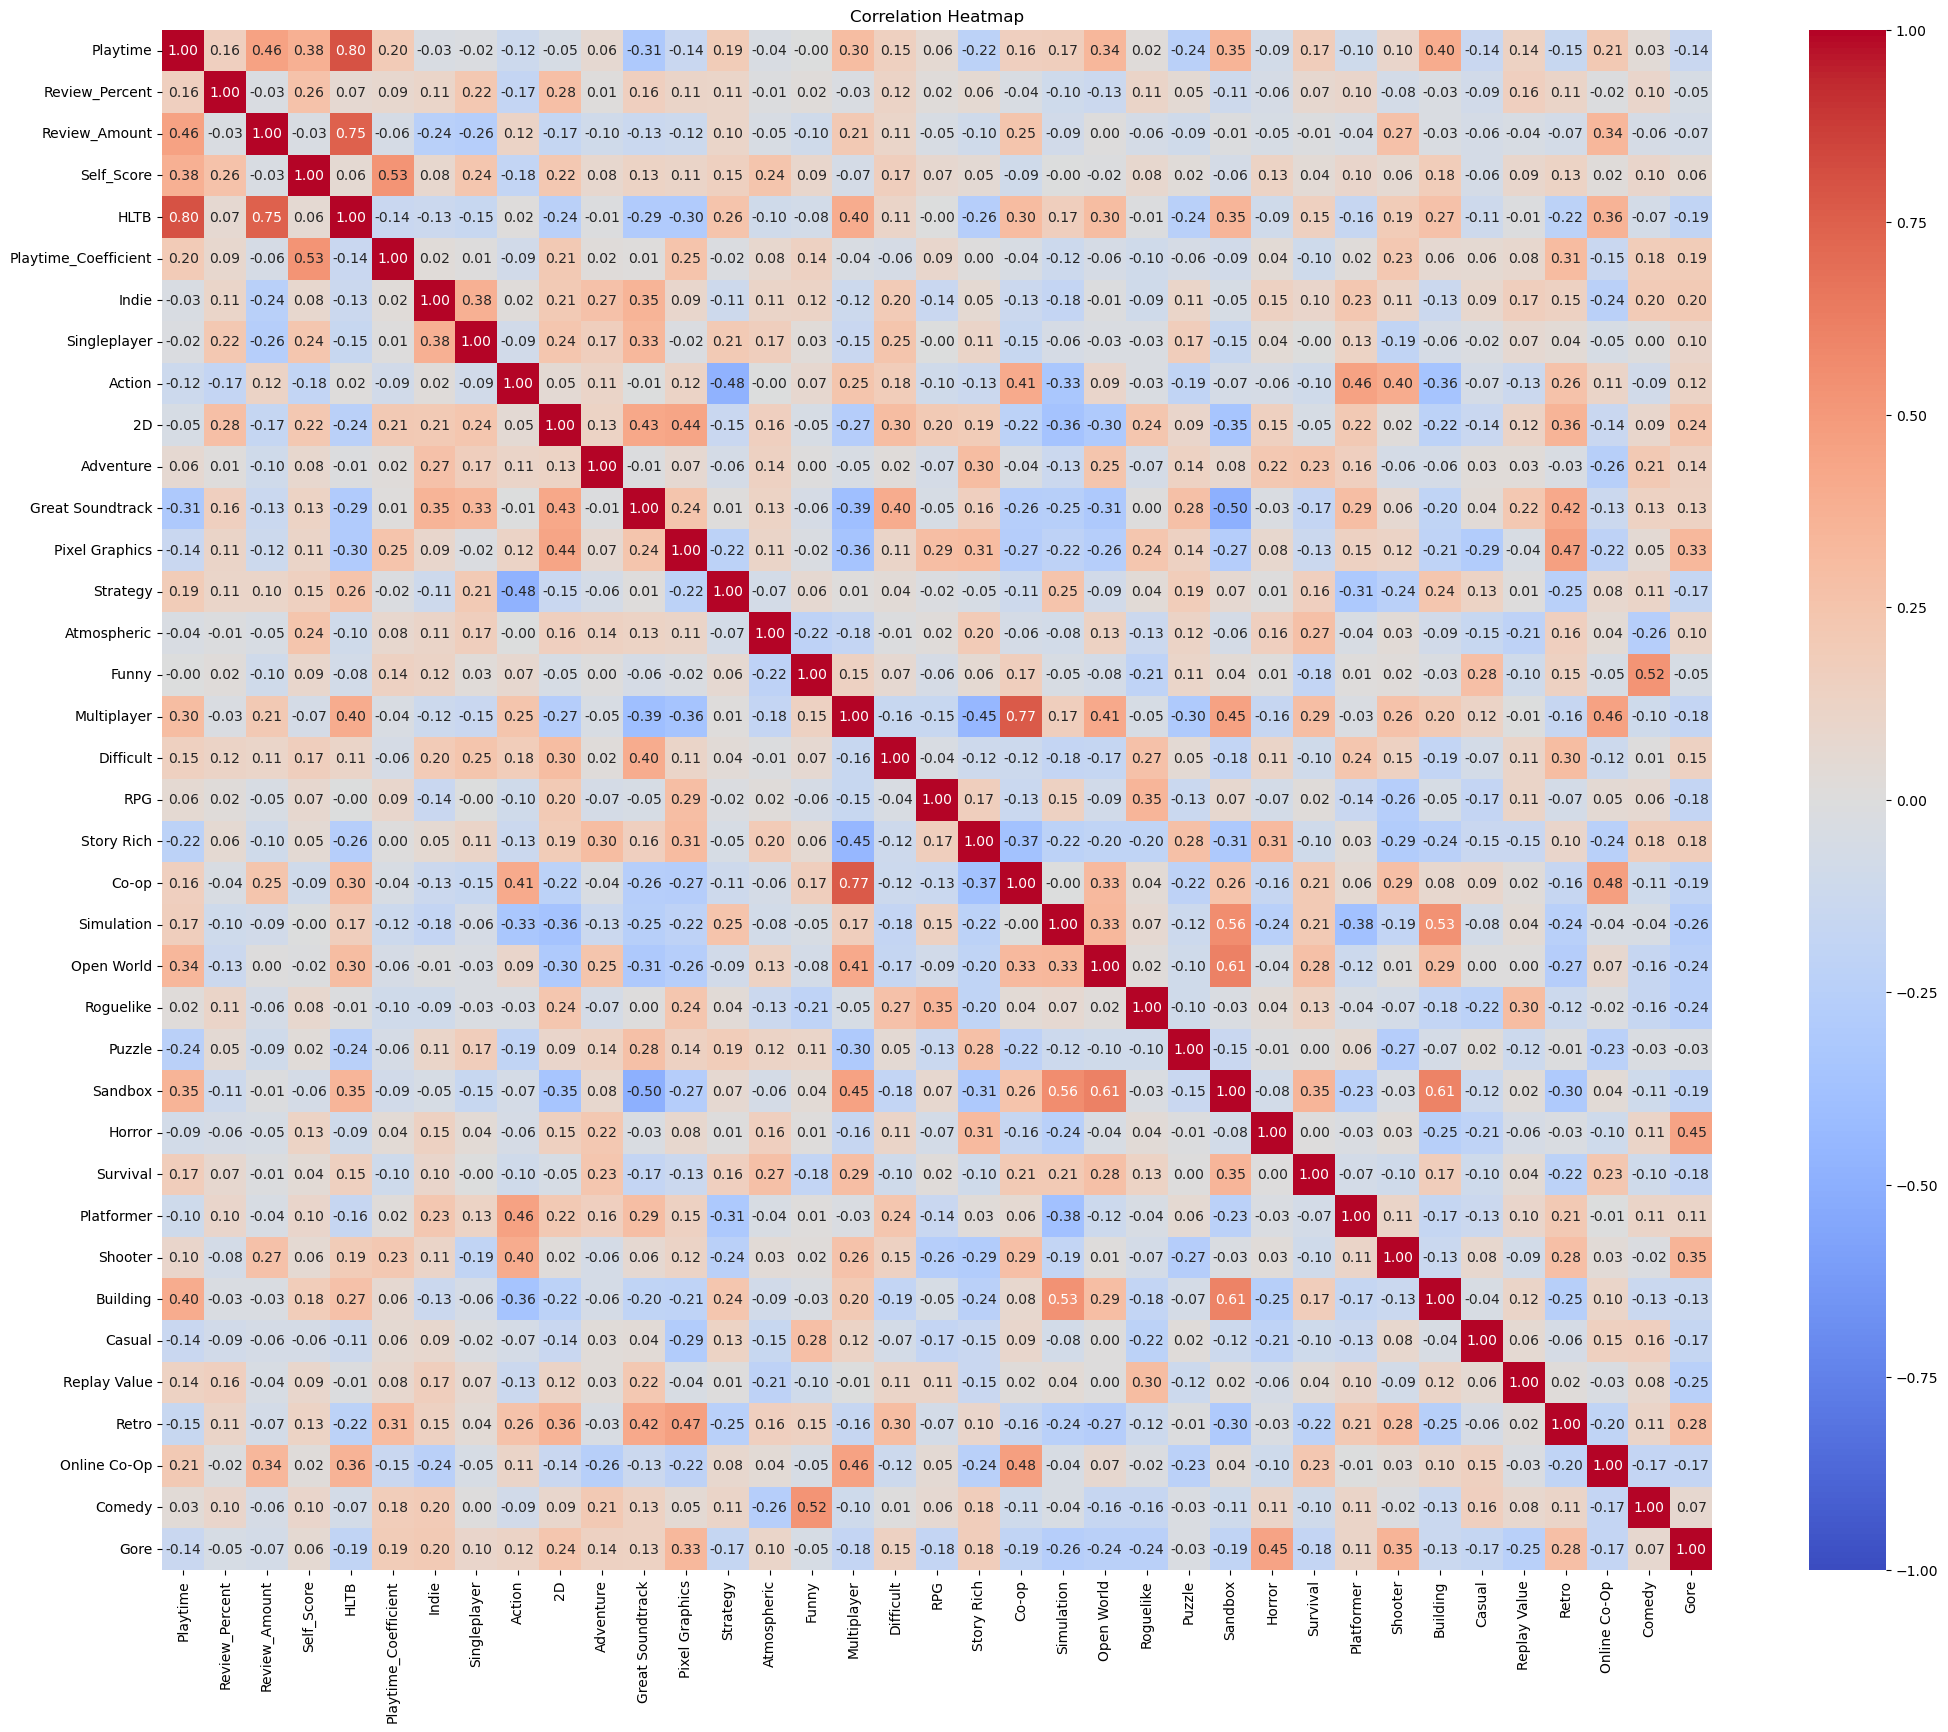

In [22]:
dfC=df.drop(columns=['Game','Tags'])

#If you want to include the games I haven't played yet you can comment out the line below 
dfC = dfC[dfC['Self_Score'] != 0]

correlation_matrix = dfC.corr()
plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

If you want to check different threshold values you can play with the variable below. It helped me see certain relations better.

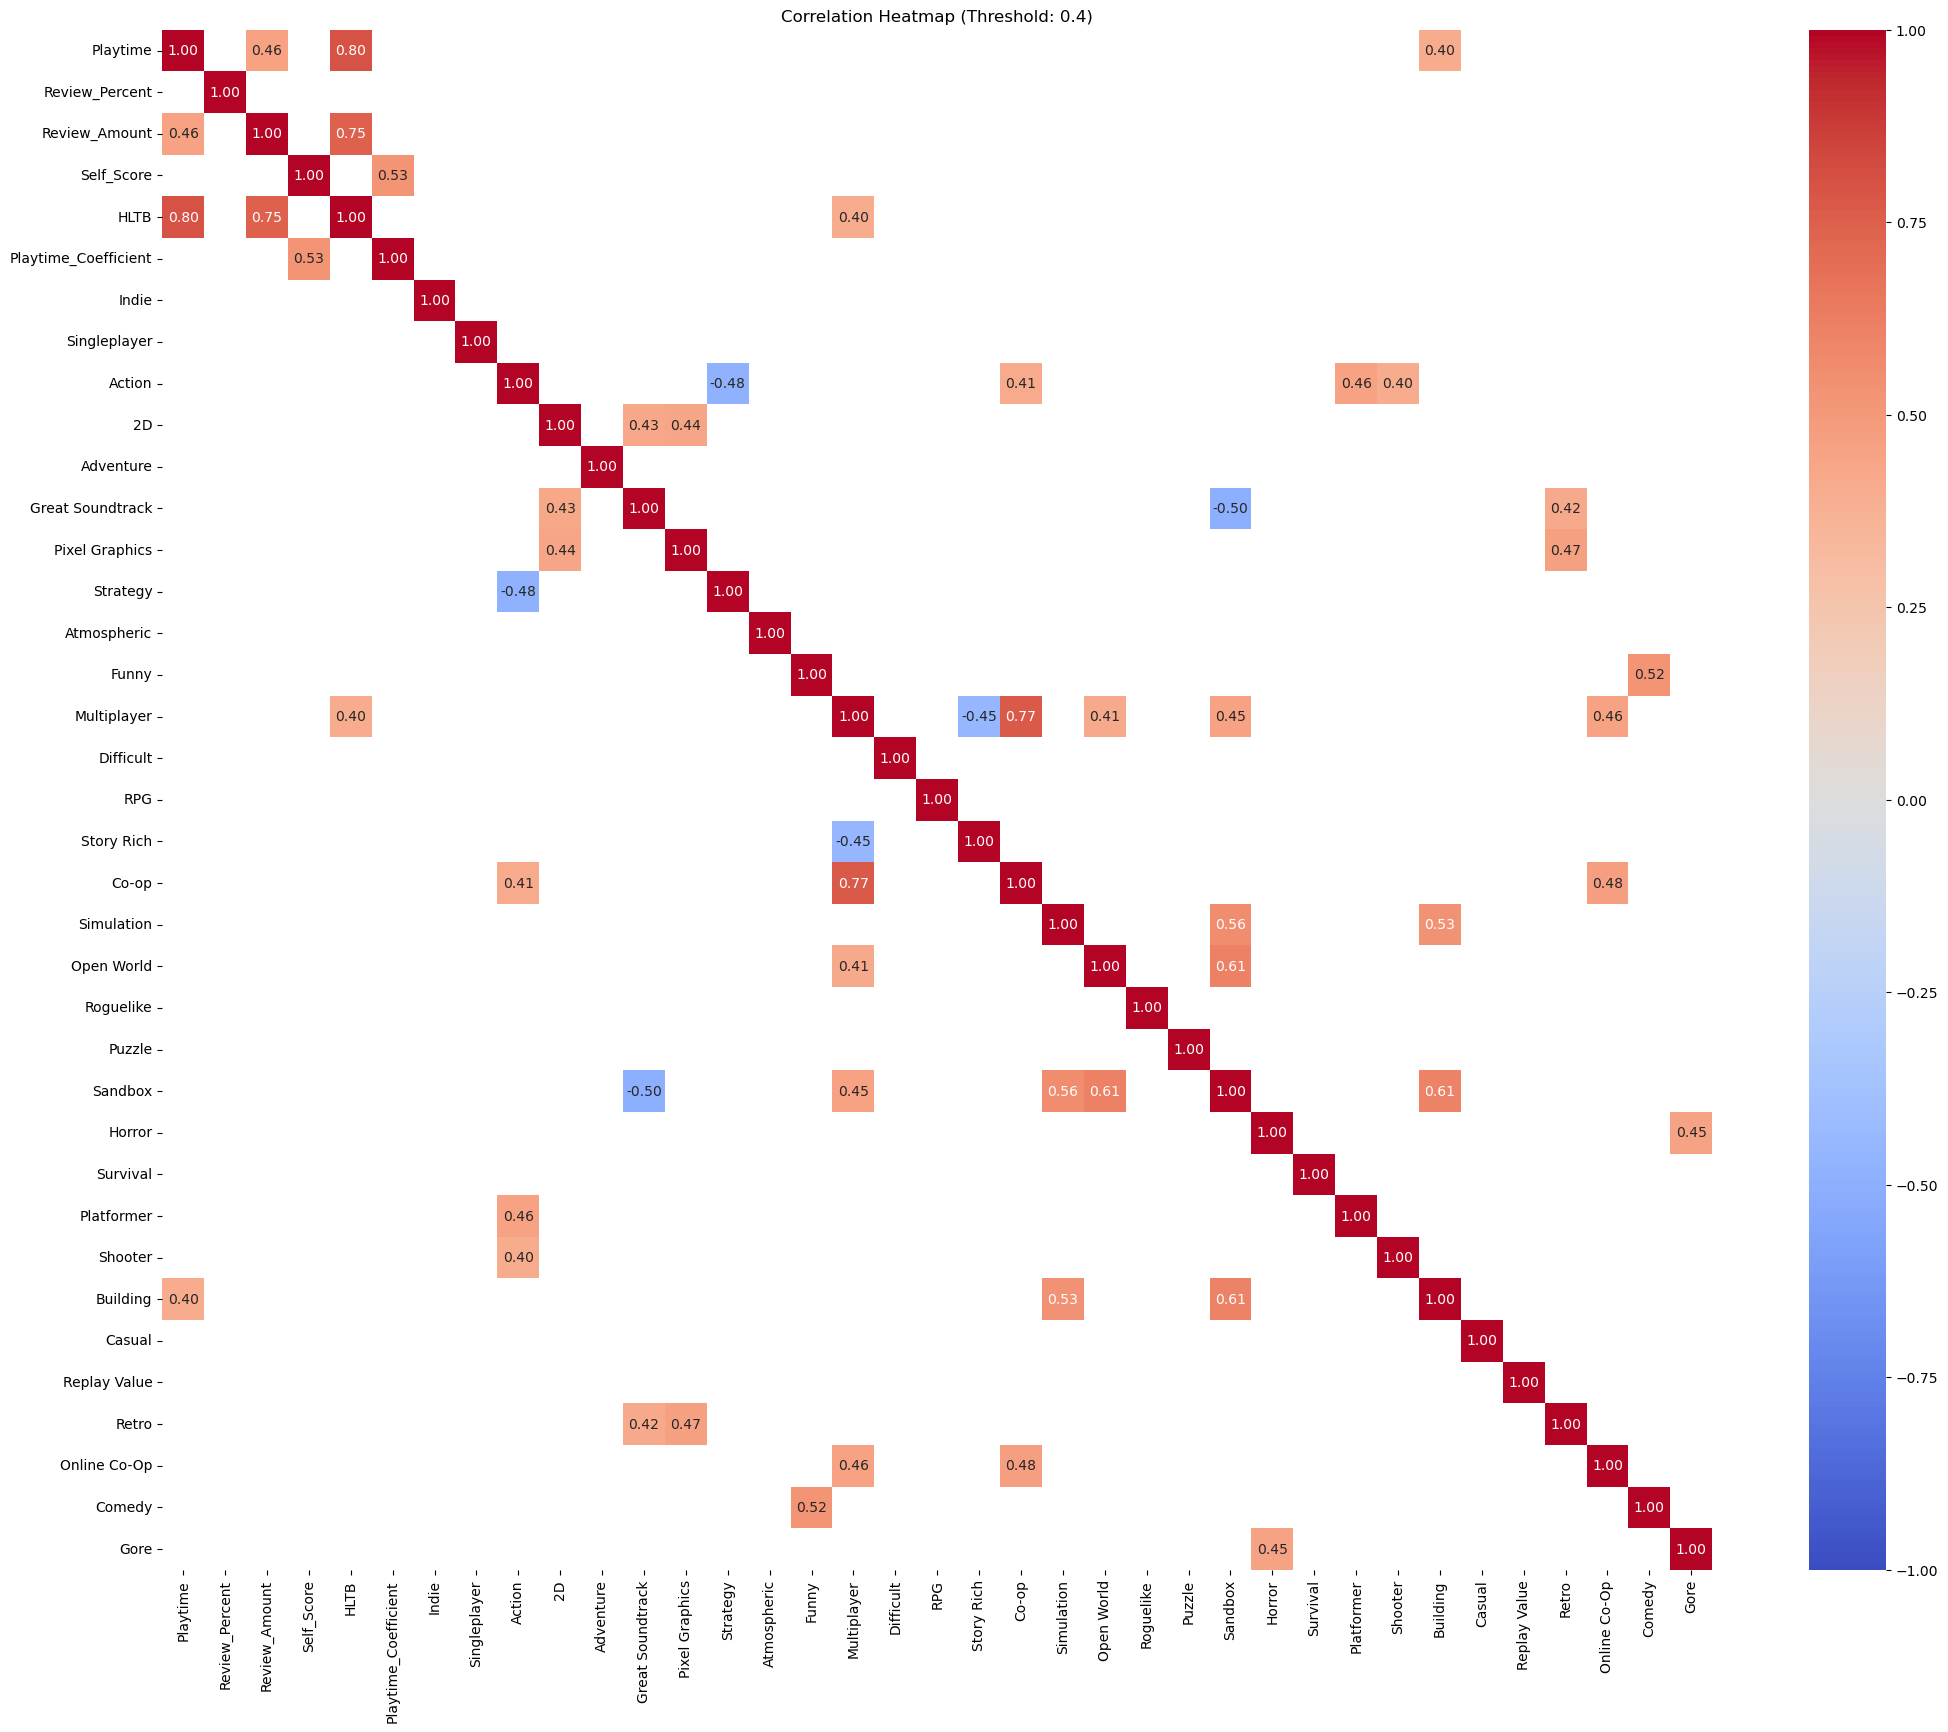

In [23]:
# Set your threshold magnitude here
threshold_magnitude = 0.40

# Filter correlations based on the threshold magnitude
filtered_correlations = correlation_matrix[
    (correlation_matrix >= threshold_magnitude) | (correlation_matrix <= -threshold_magnitude)
]
plt.figure(figsize=(25, 20))
sns.heatmap(filtered_correlations, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title(f'Correlation Heatmap (Threshold: {threshold_magnitude})')
plt.show()

Besides the Playtime_Coefficient, I tend to like games that have received better reviews, are atmospheric, singleplayer and 2D.

In [24]:
# Select all columns except the target column
selected_columns = [col for col in dfC.columns if col != 'Self_Score']

# Include the target column in the selected columns
selected_columns.append('Self_Score')

# Extract the correlation coefficients between each column and the target column
correlation_with_target = dfC[selected_columns].corr()['Self_Score'].drop('Self_Score')

# Display the correlation coefficients
print(correlation_with_target.sort_values(ascending=False))

Playtime_Coefficient    0.527673
Playtime                0.377618
Review_Percent          0.259740
Atmospheric             0.242849
Singleplayer            0.239965
2D                      0.220818
Building                0.184413
Difficult               0.168362
Strategy                0.150135
Retro                   0.130126
Horror                  0.130126
Great Soundtrack        0.127451
Pixel Graphics          0.112762
Platformer              0.098114
Comedy                  0.095009
Funny                   0.090817
Replay Value            0.090471
Adventure               0.080798
Roguelike               0.078488
Indie                   0.078349
RPG                     0.071990
Gore                    0.060338
Shooter                 0.060338
HLTB                    0.055815
Story Rich              0.049286
Survival                0.041864
Puzzle                  0.024619
Online Co-Op            0.016057
Simulation             -0.002121
Open World             -0.015454
Review_Amo

After the exclusion of the games I haven't played and few others, my already small sample size dropped to tiny value of 77. I will try to train some models from it, but my expectations are not very high.

In [31]:
print(len(dfC))

77


Here, I tried making a Regression Tree but i could not receive a satisfactory result.

In [32]:
dfC = shuffle(dfC)
X = dfC.drop(['Self_Score'], axis=1)
y = dfC[['Self_Score']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

In [65]:
# Define the hyperparameters and their possible values
param_grid = {
    'criterion': ['squared_error','absolute_error'],
    'max_depth': [None, 1, 2, 3, 4, 6],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
}

# Create a decision tree regressor
tree_reg = DecisionTreeRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring='r2')  # You can use other scoring metrics

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_tree = grid_search.best_estimator_

# Evaluate the best model on the test set
best_score = best_tree.score(X_test, y_test)

print("Best Hyperparameters:", best_params)
print("Best R-squared Score on Test Set:", best_score)

Best Hyperparameters: {'criterion': 'absolute_error', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 3}
Best R-squared Score on Test Set: -0.7525933609958508


I repeated the creation of the tree but it accuracy was varied a lot in each iteration. The ones with the highest accuracies usually used Playtime_Coefficient as decision variable in the first node, which is understandable considering its high correlation with the target variable, Self_Score.

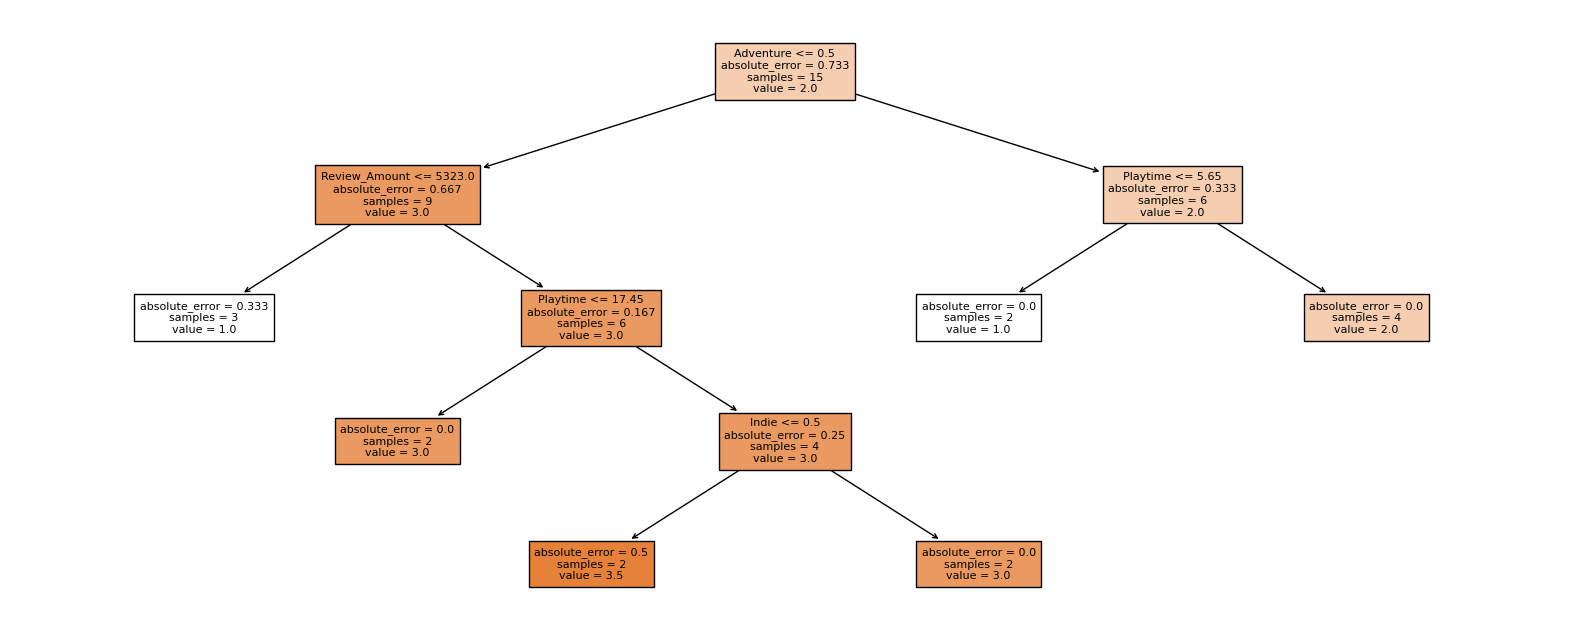

In [66]:
'''
tree = DecisionTreeRegressor(
    criterion='squared_error'
)
tree.fit(X_train, y_train)
'''
plt.figure(figsize=(20, 8))
#plot_tree(tree, filled=True, feature_names=list(X.columns), class_names=list(y.columns), fontsize=6)
plot_tree(best_tree, filled=True, feature_names=list(X.columns), fontsize=8)
plt.show()

After consideration I decided changing my scoring to a 0/1 from the previous 1-4 scale hoping that it might increase the accuracy. 1s and 2s became 0, 3s and 4s became 1.

In [43]:
dfC['Self_Score'] = dfC['Self_Score'].apply(lambda x: 0 if x in [1, 2] else 1 if x in [3, 4] else x)

Because of the changed scoring system, I also decided to switch to a Classifier Tree from the Regressor Tree. Considering the target variable having 2 options, a random guess will give a 0.5 accuracy, and the trees created seemed to be consistently above the 0.5 accuracy. I also split the test sizes 50/50 as the previous test size of 16 was extremely small.

In [54]:
#Shuffle again
dfC = shuffle(dfC)
X = dfC.drop(['Self_Score'], axis=1)
y = dfC[['Self_Score']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Define the hyperparameters and their possible values
param_grid = {
    'criterion': ['entropy'],
    'max_depth': [None, 1, 2, 3],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 'sqrt', 'log2']
}

# Create a decision tree classifier
tree_classifier = DecisionTreeClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(tree_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_tree = grid_search.best_estimator_

# Evaluate the best model on the test set
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score on Test Set:", best_score)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score on Test Set: 0.9214285714285714


The hyperparameter that consistently improved the results were 'criterion': 'entropy'.

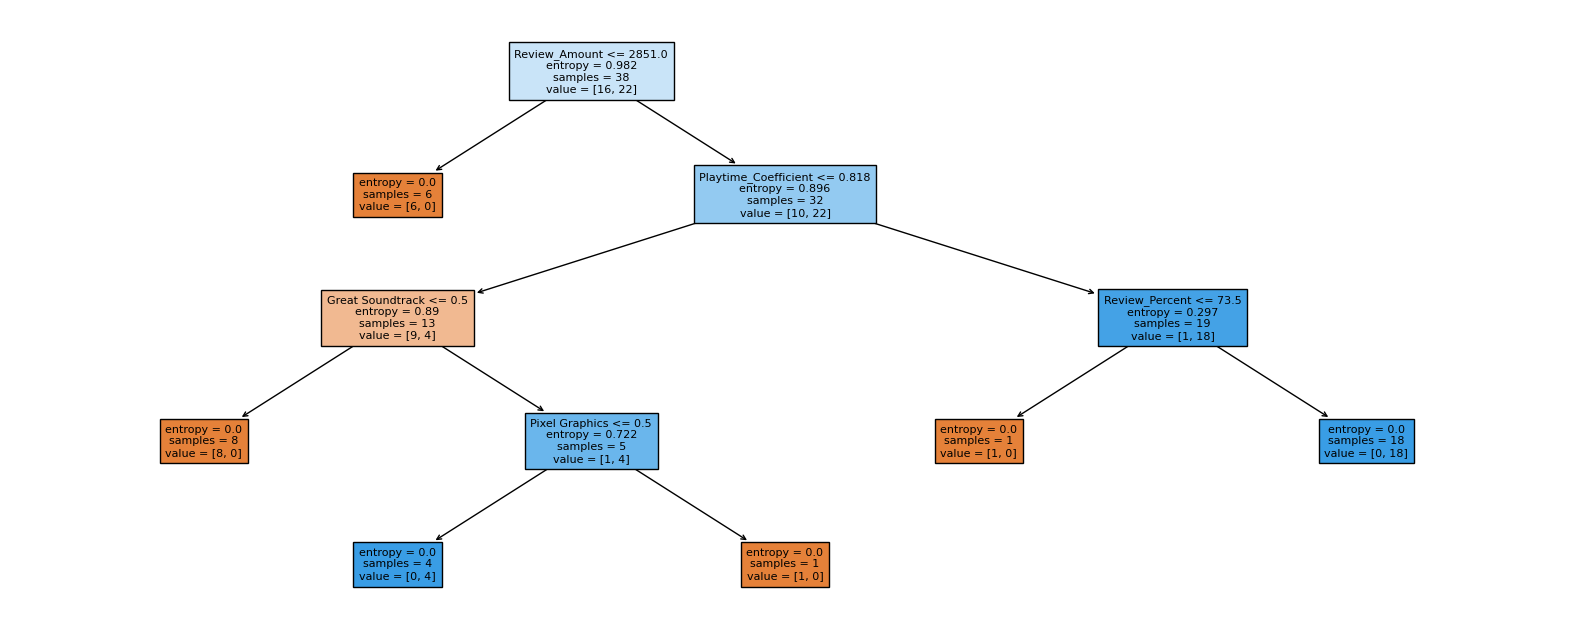

In [55]:
plt.figure(figsize=(20, 8))
#plot_tree(tree, filled=True, feature_names=list(X.columns), class_names=list(y.columns), fontsize=6)
plot_tree(best_tree, filled=True, feature_names=list(X.columns), fontsize=8)
plt.show()

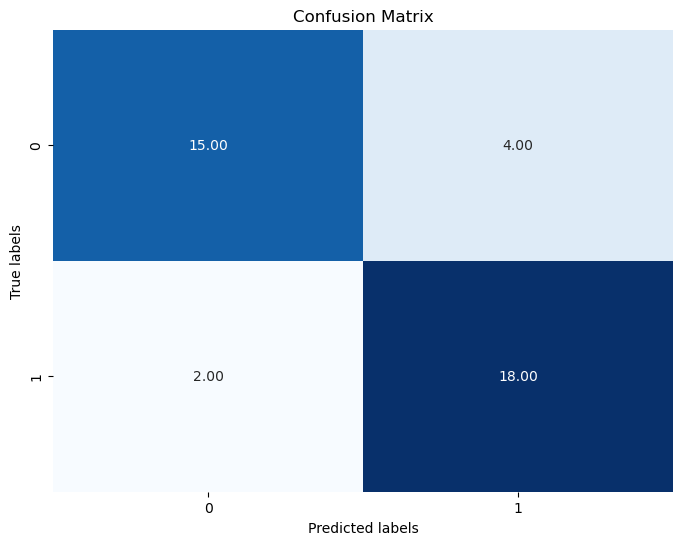

In [56]:
conf_matrix = confusion_matrix(y_test, best_tree.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='.2f', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

I decided to make a loop that will get the average of the 1000 iterations and also find the iteration with the highest accuracy. 

In [58]:
average = 0
max_accuracy = 0
for x in range(1000):
    dfC = shuffle(dfC)
    X = dfC.drop(['Self_Score'], axis=1)
    y = dfC[['Self_Score']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    tree = DecisionTreeClassifier(
        criterion='entropy'
    )
    tree.fit(X_train, y_train)
    score = tree.score(X_test, y_test)
    average = average + score
    if max_accuracy < tree.score(X_test, y_test):
        max_accuracy = score
        max_accuracy_tree = tree
average = average/1000
print("Average Accuracy: ", average)
print("Max Accuracy: ", max_accuracy)

Average Accuracy:  0.7599999999999983
Max Accuracy:  0.9487179487179487


The max accuracy tree is as follows and it mostly uses Playtime_Coefficient, Review_Percent and Review_Amount which is understandable due to their high correlation with target. *Considering the low sample size, it is very likely that the source of the high accuracy is also due to the tree getting a lucky shuffle of samples.*

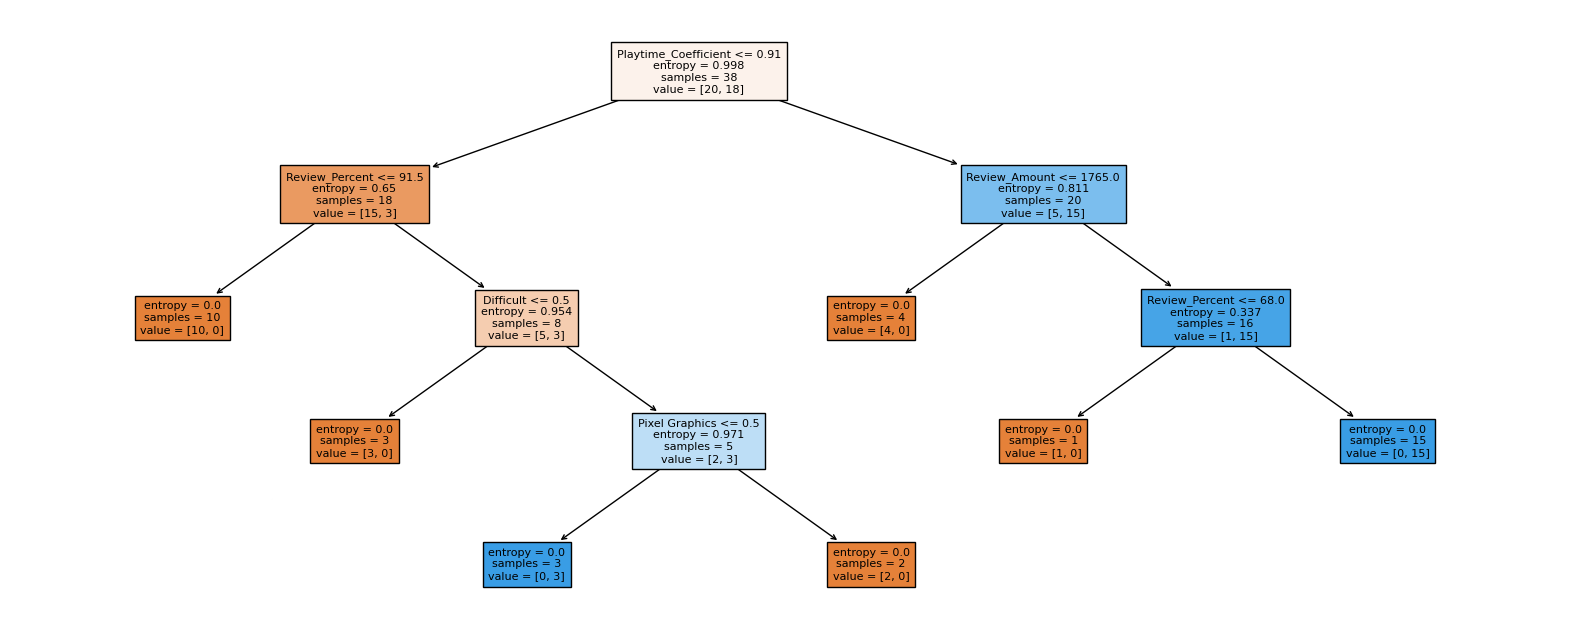

In [60]:
plt.figure(figsize=(20, 8))
#plot_tree(tree, filled=True, feature_names=list(X.columns), class_names=list(y.columns), fontsize=6)
plot_tree(max_accuracy_tree, filled=True, feature_names=list(X.columns), fontsize=8)
plt.show()

The confusion matrix of the max accuracy tree is as follows, it seems to have only mistaken one case, which further implies that the accuracy is due to a lucky shuffle.

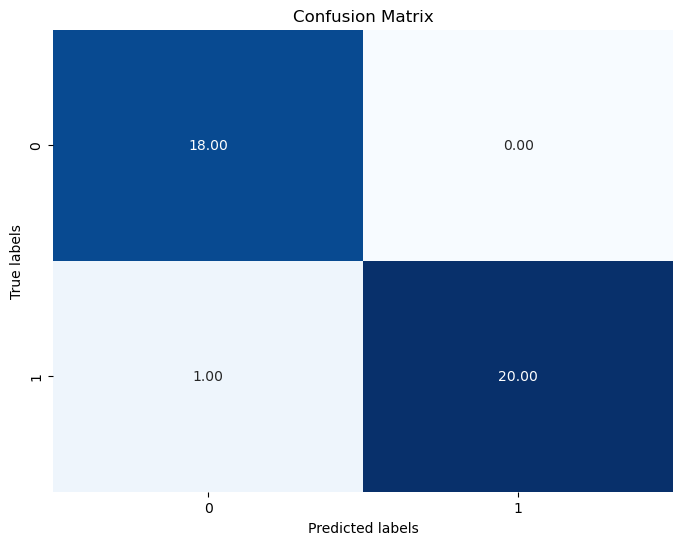

In [61]:
conf_matrix = confusion_matrix(y_test, max_accuracy_tree.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='.2f', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The average confusion matrix is as follows. Similar to the average accuracy I

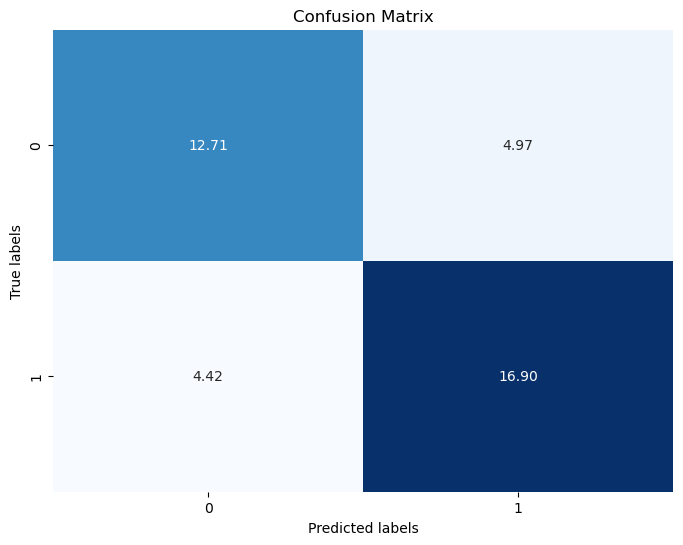

In [64]:
conf_average = [[0,0],[0,0]]
for x in range(100):
    df = shuffle(df)
    dfC = shuffle(dfC)
    X = dfC.drop(['Self_Score'], axis=1)
    y = dfC[['Self_Score']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    tree = DecisionTreeClassifier(
        criterion='entropy'
    )
    tree.fit(X_train, y_train)
    conf_matrix = confusion_matrix(y_test, tree.predict(X_test))
    conf_average = conf_average + conf_matrix
conf_average = conf_average/100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_average, annot=True, cmap="Blues", fmt='.2f', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Given acces to every sample, the tree below is created. It is likely to be overfitted, but considering the sample size its accuracy might still be higher than the average of the previous trees. Unfortunately, I can't test it on a sample but itself, which will give a not really meaningful accuracy of 1.

In [73]:
dfC = shuffle(dfC)
X = dfC.drop(['Self_Score'], axis=1)
y = dfC[['Self_Score']]
tree = DecisionTreeClassifier(
    criterion='entropy'
)
tree.fit(X, y)
score = tree.score(X, y)
print(score)

1.0


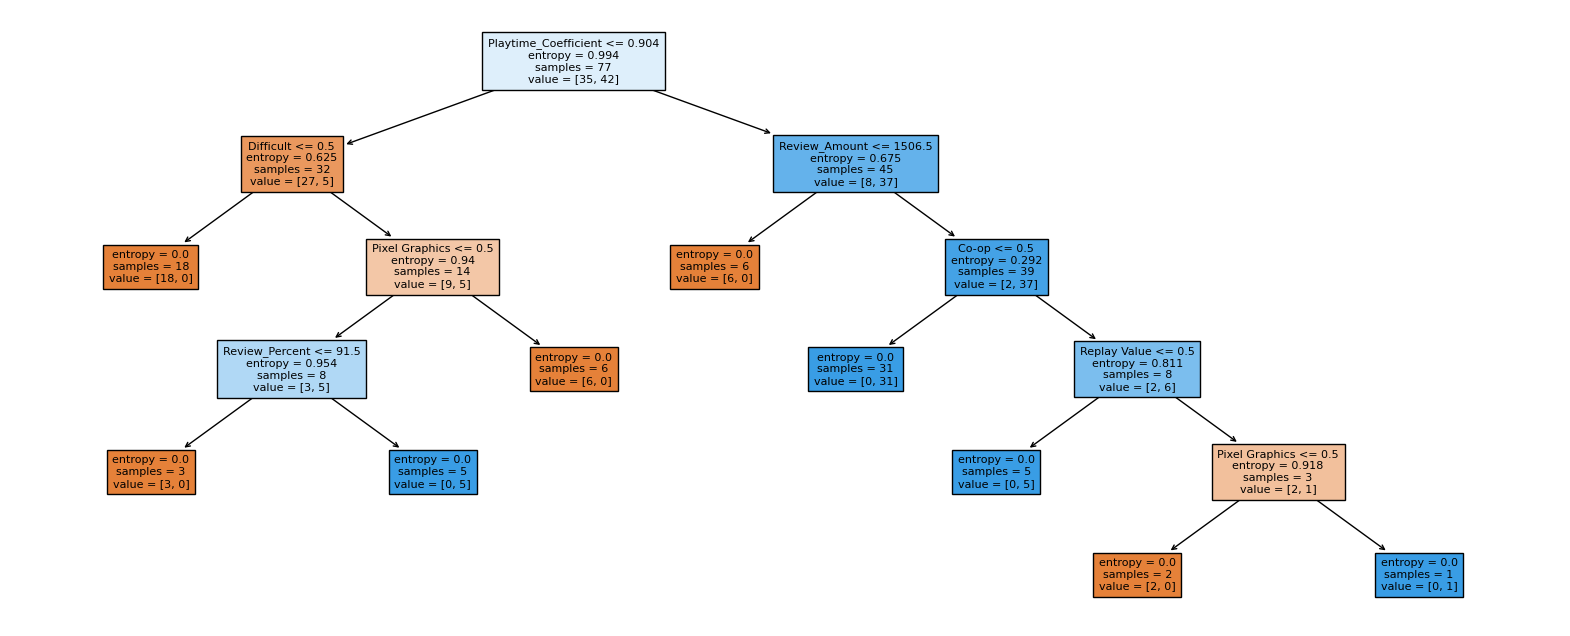

In [74]:
plt.figure(figsize=(20, 8))
#plot_tree(tree, filled=True, feature_names=list(X.columns), class_names=list(y.columns), fontsize=6)
plot_tree(tree, filled=True, feature_names=list(X.columns), fontsize=8)
plt.show()

Next step in my plan was to make a model predict if I would like a game from Steam Top Sellers or my Wishlist, basically creating a suggestion algorithm, but I decided not to. For it to work on games I haven't played yet I need to exclude the variables Playtime and Playtime_Coefficient, the ones with the highest correlation with target. Considering the already low accuracy, this will probably result in a very inaccurate tree making the process meaningless. This is also due to the fact that the tags of the games having correlation with the target significantly less than I expected them to have, leaving me without alternatives. For now, I will have to rely on Steam's suggestion algorithm.

The major problem with the project was the small sample size and I should have played more games :( . To improve the sample size I could have scraped some other platforms like Epic Games and XBox, but the data I would receive from them wouldn't fit in as they don't store similar data(tags, reviews etc.)to Steam. Perhaps I could have looked up the Steam pages for those and playtimes on the platforms' themselves. I also could have collected more data about the games like the release date, but because I didn't think it will have a significant relation with my target I decided not to.

In the end my hypothesis of "more I play a game relative to its intended playtime, higher my score for the game is" turned out to be true but my other prediction about the correlation between tags and my score was less than I expected.

-Muhammet Berke Tatar